## Installation

In [ ]:
!pip install -q --upgrade transformers datasets tokenizers 
!pip install -q emoji pythainlp sklearn-pycrfsuite seqeval
!rm -r thai2transformers thai2transformers_parent 
!git clone -b dev https://github.com/vistec-AI/thai2transformers/
!mv thai2transformers thai2transformers_parent
!mv thai2transformers_parent/thai2transformers .
!pip install accelerate==0.5.1
!apt install git-lfs
!pip install sentencepiece

! git clone https://github.com/Bjarten/early-stopping-pytorch.git
import sys  
sys.path.insert(0, '/content/early-stopping-pytorch')

     |████████████████████████████████| 4.2 MB 7.3 MB/s 
     |████████████████████████████████| 346 kB 60.3 MB/s 
     |████████████████████████████████| 6.6 MB 45.3 MB/s 
     |████████████████████████████████| 86 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 62.3 MB/s 
     |████████████████████████████████| 212 kB 59.9 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 49.9 MB/s 
     |████████████████████████████████| 140 kB 65.2 MB/s 
     |████████████████████████████████| 127 kB 63.0 MB/s 
     |████████████████████████████████| 271 kB 70.0 MB/s 
     |████████████████████████████████| 144 kB 75.6 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is 

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

## Importing the libraries



In [ ]:
from datasets import load_dataset,Dataset,DatasetDict,load_from_disk
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, Trainer, TrainingArguments,AutoTokenizer,AutoModel,AutoConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from thai2transformers.preprocess import process_transformers
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from pytorchtools import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the dataset

In [ ]:
data = load_from_disk('/content/drive/MyDrive/Fake news/News-Dataset/dataset')

In [ ]:
def clean_function(examples):
   examples['text'] = process_transformers(examples['text'])
   return examples
data = data.map(clean_function)

Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/train/cache-9aaf53670437ac28.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/test/cache-f75cfba6eebda1fc.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/valid/cache-b331ba61eb8a3b56.arrow


## Fine-tuning

In [ ]:
checkpoint = "airesearch/wangchanberta-base-att-spm-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.model_max_len=416

Downloading:   0%|          | 0.00/282 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/883k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
  return tokenizer(batch["text"], truncation=True,max_length=416)

tokenized_dataset = data.map(tokenize, batched=True)
tokenized_dataset

Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/train/cache-1231022e8a5cbde4.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/test/cache-19daeb334c4d5f5e.arrow
Loading cached processed dataset at /content/drive/MyDrive/Fake news/News-Dataset/dataset/valid/cache-c4aced047a8102a4.arrow


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 2430
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 676
    })
    valid: Dataset({
        features: ['text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 270
    })
})

In [ ]:
tokenized_dataset.set_format("torch",columns=["input_ids", "attention_mask", "labels"])
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
class extract_tensor(nn.Module):
    def forward(self,x):
        # Output shape (batch, features, hidden)
        tensor, _ = x
        # Reshape shape (batch, hidden)
        return tensor[:, :]

In [ ]:
class CustomModel(nn.Module):
  def __init__(self,checkpoint,num_labels): 
    super(CustomModel,self).__init__() 
    self.num_labels = num_labels 

    #Load Model with given checkpoint and extract its body
    self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
    self.dropout = nn.Dropout(0.1) 
    self.classifier = nn.Sequential(
      nn.LSTM(768, 256, 1, batch_first=True),
      extract_tensor(),
      nn.Linear(256, 2)
    )

  def forward(self, input_ids=None, attention_mask=None,labels=None):
    #Extract outputs from the body
    outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

    #Add custom layers
    sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

    logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses
    
    loss = None
    if labels is not None:
      loss_fct = nn.CrossEntropyLoss()
      loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    
    return SequenceClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=CustomModel(checkpoint=checkpoint,num_labels=2).to(device)

Downloading:   0%|          | 0.00/404M [00:00<?, ?B/s]

Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertModel: ['lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    tokenized_dataset["train"], shuffle=True, batch_size=8, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_dataset["valid"], batch_size=8, collate_fn=data_collator
)

In [ ]:
from transformers import AdamW,get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 50
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

15200


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from datasets import load_metric
metric = load_metric("f1")


In [ ]:
from tqdm.auto import tqdm

progress_bar_train = tqdm(range(num_training_steps))
progress_bar_eval = tqdm(range(num_epochs * len(eval_dataloader)))
# to track the training loss as the model trains
train_losses = []
# to track the validation loss as the model trains
valid_losses = []
# to track the average training loss per epoch as the model trains
avg_train_losses = []
# to track the average validation loss per epoch as the model trains
avg_valid_losses = [] 

early_stopping = EarlyStopping(patience=7, verbose=True)

for epoch in range(num_epochs):
  model.train()
  size = len(train_dataloader.dataset)
  for batch, X in enumerate(train_dataloader):
      X = {k: v.to(device) for k, v in X.items()}
      outputs = model(**X)
      loss = outputs.loss
      loss.backward()

      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      progress_bar_train.update(1)
      train_losses.append(loss.item())

  model.eval()
  for batch, X in enumerate(eval_dataloader):
    X = {k: v.to(device) for k, v in X.items()}
    with torch.no_grad():
        outputs = model(**X)
        loss = outputs.loss
        valid_losses.append(loss.item())

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=X["labels"])
    progress_bar_eval.update(1)

  # print training/validation statistics 
  # calculate average loss over an epoch
  train_loss = np.average(train_losses)
  valid_loss = np.average(valid_losses)
  avg_train_losses.append(train_loss)
  avg_valid_losses.append(valid_loss)
        
  epoch_len = len(str(num_epochs))
        
  loss_msg = (f'[{epoch+1:>{epoch_len}}/{num_epochs:>{epoch_len}}] ' +
              f'train_loss: {train_loss:.5f} ' +
              f'valid_loss: {valid_loss:.5f}')
        
  print(loss_msg)

  # clear lists to track next epoch
  train_losses = []
  valid_losses = []
  # early_stopping needs the validation loss to check if it has decresed, 
  # and if it has, it will make a checkpoint of the current model
  early_stopping(valid_loss, model)
        
  if early_stopping.early_stop:
    print("Early stopping")
    break
  print(metric.compute())
  print('\n')

      

  0%|          | 0/15200 [00:00<?, ?it/s]

  0%|          | 0/1700 [00:00<?, ?it/s]

[ 1/50] train_loss: 0.44766 valid_loss: 0.40799
Validation loss decreased (inf --> 0.407988).  Saving model ...
{'f1': 0.8634920634920634}


[ 2/50] train_loss: 0.41904 valid_loss: 0.44579
EarlyStopping counter: 1 out of 7
{'f1': 0.875}


[ 3/50] train_loss: 0.35022 valid_loss: 0.40008
Validation loss decreased (0.407988 --> 0.400082).  Saving model ...
{'f1': 0.8695652173913043}


[ 4/50] train_loss: 0.31232 valid_loss: 0.48532
EarlyStopping counter: 1 out of 7
{'f1': 0.8516129032258064}


[ 5/50] train_loss: 0.30712 valid_loss: 0.41205
EarlyStopping counter: 2 out of 7
{'f1': 0.8656716417910447}


[ 6/50] train_loss: 0.24519 valid_loss: 0.36756
Validation loss decreased (0.400082 --> 0.367557).  Saving model ...
{'f1': 0.8783783783783784}


[ 7/50] train_loss: 0.36710 valid_loss: 0.66978
EarlyStopping counter: 1 out of 7
{'f1': 0.7463414634146343}


[ 8/50] train_loss: 0.49594 valid_loss: 0.60676
EarlyStopping counter: 2 out of 7
{'f1': 0.8271954674220964}


[ 9/50] train_loss: 0.325

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

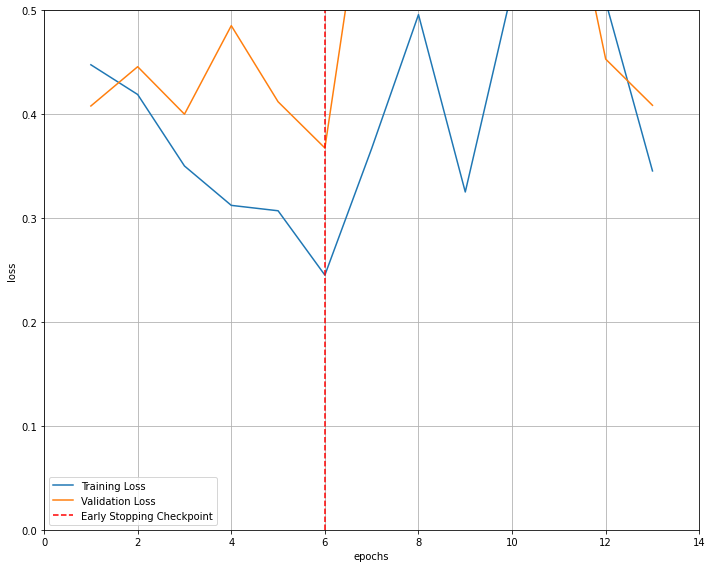

In [ ]:
# visualize the loss as the network trained
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(avg_train_losses)+1),avg_train_losses, label='Training Loss')
plt.plot(range(1,len(avg_valid_losses)+1),avg_valid_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = avg_valid_losses.index(min(avg_valid_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(avg_train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Test Result

In [ ]:
preds = torch.empty(0).cuda()

model.eval()

test_dataloader = DataLoader(
    tokenized_dataset["test"], batch_size=8, collate_fn=data_collator
)

for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])
    preds = torch.cat((preds, predictions), 0)

metric.compute()

{'f1': 0.8969578017664378}

In [ ]:
text = tokenized_dataset["test"]["text"]

In [ ]:
y_true = tokenized_dataset["test"]["labels"]
y_pred = preds.cpu()
print(classification_report(y_true, y_pred, target_names=['true','fake']))

              precision    recall  f1-score   support

        true       0.88      0.90      0.89       324
        fake       0.91      0.89      0.90       352

    accuracy                           0.89       676
   macro avg       0.89      0.90      0.89       676
weighted avg       0.90      0.89      0.90       676



## Wrong Prediction

In [ ]:
test_result = pd.DataFrame(zip(text, [int(x) for x in y_pred.tolist()], y_true.tolist()), columns=['text','pred','true'])
wrong_prediction = test_result[test_result['pred'] != test_result['true']]
wrong_prediction.head()

,text,pred,true
9,ชาวอู่ฮั่นตะโกนให้กำลังใจกันและกันขอให้เข้มแข็...,0,1
17,7สัญญาณว่าคุณดื่มกาแฟ“มากเกินไป”เพราะสุขภาพร่า...,1,0
68,ต้องหัดกินนะ!ยอดอ่อนมะม่วงหิมพานต์กินชะลอแก่แล...,1,0
75,สุดยอดความอร่อย!!“น้ำผักสะทอน”พืชพื้นบ้านต้มเค...,0,1
91,บอกลาต้นแขนใหญ่ย้วย–ขาต้นสนุ๊กง่ายๆด้วยเทคนิคน...,1,0


## Confusion Matrix

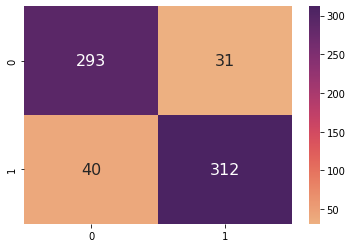

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sn
array = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(array, range(2), range(2))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cmap="flare") 
plt.show()

In [ ]:
torch.save(model, '/content/drive/MyDrive/Fake news/Model/sodabert-lstm')